## FDMS TME3  

Kaggle [How Much Did It Rain? II](https://www.kaggle.com/c/how-much-did-it-rain-ii)

Florian Toque & Paul Willot  

### Notes
We tried different model, like SVM regression, MLP, Random Forest and KNN as recommanded by the winning team of the Kaggle on taxi trajectories. So far Random Forest seems to be the best, slightly better than the SVM.  
The new features we exctracted only made a very small impact on predictions.

In [2]:
# from __future__ import exam_success
from __future__ import absolute_import
from __future__ import print_function

%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import scipy.stats as stats

# Sk cheats
from sklearn.cross_validation import cross_val_score  # cross val
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import Imputer   # get rid of nan

* 13.765.202 lines in train.csv  
*  8.022.757 lines in test.csv  

### Few words about the dataset

Predictions is made in the USA corn growing states (mainly Iowa, Illinois, Indiana) during the season with the highest rainfall (as illustrated by [Iowa](https://en.wikipedia.org/wiki/Iowa#Climate) for the april to august months)

The Kaggle page indicate that the dataset have been shuffled, so working on a subset seems acceptable  
The test set is not a extracted from the same data as the training set however, which make the evaluation trickier

### Load the dataset

In [3]:
%%time
filename = "data/reduced_train_100000.csv"
#filename = "data/reduced_train_100000.csv"
raw = pd.read_csv(filename)
raw = raw.set_index('Id')

CPU times: user 233 ms, sys: 40.5 ms, total: 274 ms
Wall time: 284 ms


In [4]:
raw['Expected'].describe()

count    100000.000000
mean        129.579825
std         687.622542
min           0.010000
25%           0.254000
50%           1.016000
75%           3.556002
max       32740.617000
Name: Expected, dtype: float64

Per wikipedia, a **value of more than 421 mm/h is considered "Extreme/large hail"**  
If we encounter the value 327.40 meter per hour, we should probably start building Noah's ark  
Therefor, it seems reasonable to **drop values too large**, considered as outliers

In [5]:
# Considering that the gauge may concentrate the rainfall, we set the cap to 1000
# Comment this line to analyse the complete dataset 
l = len(raw)
raw = raw[raw['Expected'] < 1000]
print("Dropped %d (%0.2f%%)"%(l-len(raw),(l-len(raw))/float(l)*100))

Dropped 4175 (4.17%)


In [6]:
raw.head(5)

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id,,,,,,,,,,,,,,,,,,,,,
1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


In [7]:
raw.describe()

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,95825.000000,95825.000000,44990.000000,38441.000000,45146.000000,53163.000000,48020.000000,42275.000000,48117.000000,55260.000000,...,42210.000000,36040.000000,30901.000000,36025.000000,42210.000000,31318.000000,26464.000000,31368.000000,36627.000000,95825.000000
mean,29.686595,11.052523,23.684530,20.789496,23.378716,26.419606,25.422845,22.955328,25.136573,27.966965,...,1.014748,0.597368,-0.565218,0.428472,2.017049,-0.011121,-3.384371,-0.431668,3.854969,17.433421
std,17.417786,4.239598,10.227057,9.074095,9.939687,11.193085,10.630984,9.639113,10.377139,11.544993,...,0.045614,1.387422,0.973801,0.865122,1.539430,3.747653,2.772211,2.202447,3.761289,84.809357
min,0.000000,0.000000,-29.000000,-31.500000,-31.500000,-26.500000,-26.500000,-27.500000,-25.000000,-23.000000,...,0.208333,-7.875000,-7.875000,-7.875000,-7.875000,-52.880005,-51.420000,-46.870010,-41.540010,0.010000
25%,15.000000,9.000000,17.500000,15.500000,17.500000,19.500000,19.000000,17.500000,18.500000,20.500000,...,0.998333,-0.062500,-1.000000,0.062500,1.125000,-1.410004,-4.230011,-0.710007,1.759994,0.254000
50%,30.000000,12.000000,24.000000,21.000000,23.500000,27.000000,25.500000,23.000000,25.500000,28.500000,...,1.005000,0.500000,-0.500000,0.375000,1.687500,0.000000,-2.809998,0.000000,3.169998,1.016000
75%,45.000000,14.000000,30.500000,27.000000,30.500000,34.500000,33.000000,29.500000,32.500000,36.500000,...,1.051667,1.125000,0.000000,0.750000,2.500000,1.409988,-1.740006,0.349991,5.289993,3.048001
max,59.000000,21.000000,64.500000,57.000000,61.500000,67.500000,68.000000,59.500000,64.000000,79.500000,...,1.051667,7.937500,5.937500,7.937500,7.937500,47.849990,1.759994,5.629990,43.209990,876.300500


We regroup the data by ID

In [8]:
# We select all features except for the minutes past,
# because we ignore the time repartition of the sequence for now

features_columns = list([u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])

def getXy(raw):
    selected_columns = list([ u'minutes_past',u'radardist_km', u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])
    
    data = raw[selected_columns]
    
    docX, docY = [], []
    for i in data.index.unique():
        if isinstance(data.loc[i],pd.core.series.Series):
            m = [data.loc[i].as_matrix()]
            docX.append(m)
            docY.append(float(raw.loc[i]["Expected"]))
        else:
            m = data.loc[i].as_matrix()
            docX.append(m)
            docY.append(float(raw.loc[i][:1]["Expected"]))
    X , y = np.array(docX) , np.array(docY)
    return X,y

### On fully filled dataset

In [9]:
#noAnyNan = raw.loc[raw[features_columns].dropna(how='any').index.unique()]
noAnyNan = raw.dropna()

In [10]:
noFullNan = raw.loc[raw[features_columns].dropna(how='all').index.unique()]

In [11]:
fullNan = raw.drop(raw[features_columns].dropna(how='all').index)

---
# Predicitons


As a first try, we make predictions on the complete data, and return the 50th percentile and uncomplete and fully empty data

In [12]:
%%time
X,y=getXy(noAnyNan)

CPU times: user 1.89 s, sys: 17 ms, total: 1.91 s
Wall time: 1.92 s


In [13]:
%%time
#XX = [np.array(t).mean(0) for t in X]
XX = [np.append(np.nanmean(np.array(t),0),(np.array(t)[1:] - np.array(t)[:-1]).sum(0) ) for t in X]

CPU times: user 177 ms, sys: 5.26 ms, total: 182 ms
Wall time: 181 ms


In [17]:
t = X[0]

In [30]:
t

array([[  1.        ,   2.        ,   9.        ,   5.        ,
          7.5       ,  10.5       ,  15.        ,  10.5       ,
         16.5       ,  23.5       ,   0.99833333,   0.99833333,
          0.99833333,   0.99833333,   0.375     ,  -0.125     ,
          0.3125    ,   0.875     ,   1.0599976 ,  -1.4100037 ,
         -0.3500061 ,   1.0599976 ],
       [ 16.        ,   2.        ,  18.        ,  14.        ,
         17.5       ,  21.        ,  20.5       ,  18.        ,
         20.5       ,  23.        ,   0.995     ,   0.995     ,
          0.99833333,   1.0016667 ,   0.25      ,   0.125     ,
          0.375     ,   0.6875    ,   0.34999084,  -1.0599976 ,
          0.        ,   1.0599976 ],
       [ 21.        ,   2.        ,  24.5       ,  16.5       ,
         21.        ,  24.5       ,  24.5       ,  21.        ,
         24.        ,  28.        ,   0.99833333,   0.995     ,
          0.99833333,   0.99833333,   0.25      ,   0.0625    ,
          0.1875    ,   0.5625

In [31]:
np.percentile(t,50,axis=0)

array([ 31.        ,   2.        ,  14.        ,  14.        ,
        17.5       ,  21.        ,  19.5       ,  18.        ,
        21.        ,  23.        ,   0.99833333,   0.995     ,
         0.99833333,   0.99833333,   0.375     ,   0.1875    ,
         0.4375    ,   0.6875    ,  -0.3500061 ,  -1.4100037 ,
        -0.3500061 ,   1.0599976 ])

In [32]:
XX=[]
for t in X:
    #print(idx)
    
    tmp = np.append(np.nanmean(np.array(t),0),(np.array(t)[1:] - np.array(t)[:-1]).sum(0) )
    tmp = np.append(tmp,np.percentile(t,10,axis=0))
    tmp = np.append(tmp,np.percentile(t,50,axis=0))
    tmp = np.append(tmp,np.percentile(t,90,axis=0))
    test = t
    
    try:
        taa=test[:,0]
    except TypeError:
        taa=[test[0][0]]
    valid_time = np.zeros_like(taa)
    valid_time[0] = taa[0]
    for n in xrange(1,len(taa)):
        valid_time[n] = taa[n] - taa[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    
    sum=0
    try:
        column_ref=test[:,2]
    except TypeError:
        column_ref=[test[0][2]]
    for dbz, hours in zip(column_ref, valid_time):
        # See: https://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
            
    #XX.append(np.append(np.array(sum),tmp))
    #XX.append(np.array([sum]))
    XX.append(tmp)


In [16]:
XX[0]

array([  4.48764871e-01,   3.04444444e+01,   2.00000000e+00,
         1.43888889e+01,   1.21666667e+01,   1.55555556e+01,
         1.92222222e+01,   2.08333333e+01,   1.86666667e+01,
         2.13888889e+01,   2.44444444e+01,   9.97962960e-01,
         9.94629637e-01,   9.98333330e-01,   9.99074079e-01,
         4.23611111e-01,   1.66666667e-01,   4.51388889e-01,
         7.98611111e-01,  -2.34449602e-01,  -1.44889326e+00,
        -3.12227033e-01,   1.05888367e+00,   5.20000000e+01,
         0.00000000e+00,   7.00000000e+00,   9.50000000e+00,
         1.05000000e+01,   1.30000000e+01,   1.30000000e+01,
         1.30000000e+01,   1.00000000e+01,   6.00000000e+00,
         0.00000000e+00,  -6.66663000e-03,   0.00000000e+00,
         0.00000000e+00,   5.00000000e-01,   7.50000000e-01,
         6.25000000e-01,   5.00000000e-01,  -1.41000370e+00,
         0.00000000e+00,   0.00000000e+00,   1.05999740e+00])

In [263]:
XX[2]

array([ 0.59982168])

In [33]:
def splitTrainTest(X, y, split=0.2):
    tmp1, tmp2 = [], []
    ps = int(len(X) * (1-split))
    index_shuf = range(len(X))
    random.shuffle(index_shuf)
    for i in index_shuf:
        tmp1.append(X[i])
        tmp2.append(y[i])
    return tmp1[:ps], tmp2[:ps], tmp1[ps:], tmp2[ps:]

In [34]:
X_train,y_train, X_test, y_test = splitTrainTest(XX,y)

---

In [225]:
from sklearn import svm

In [283]:
svr = svm.SVR(C=100000)

In [284]:
%%time
srv = svr.fit(X_train,y_train)

CPU times: user 1.16 s, sys: 9.79 ms, total: 1.17 s
Wall time: 1.18 s


In [240]:
err = (svr.predict(X_test)-y_test)**2
err.sum()/len(err)

68.94416640518908

In [285]:
err = (svr.predict(X_test)-y_test)**2
err.sum()/len(err)

748.02998632366246

In [241]:
%%time
svr_score = cross_val_score(svr, XX, y, cv=5)
print("Score: %s\tMean: %.03f"%(svr_score,svr_score.mean()))

Score: [ 0.00178716 -0.01275117  0.00367807 -0.01291184 -0.00668543]	Mean: -0.005
CPU times: user 1.76 s, sys: 27.7 ms, total: 1.79 s
Wall time: 1.8 s


---

In [367]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import grid_search

In [378]:
knn = KNeighborsRegressor(n_neighbors=6,weights='distance')

In [ ]:
parameters = {'weights':('distance','uniform'),'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute')}
grid_knn = grid_search.GridSearchCV(knn, parameters,n_jobs=2)

In [ ]:
%%time
grid_knn.fit(X_train,y_train)

In [ ]:
print(grid_knn.grid_scores_)
print("Best: ",grid_knn.best_params_)

In [375]:
knn = grid_knn.best_estimator_

In [379]:
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=6, p=2, weights='distance')

In [380]:
err = (knn.predict(X_test)-y_test)**2
err.sum()/len(err)

777.3484598901299

---

In [35]:
etreg = ExtraTreesRegressor(n_estimators=200, max_depth=None, min_samples_split=1, random_state=0)

In [69]:
parameters = {'n_estimators':range(100,200,20)}
grid_rf = grid_search.GridSearchCV(etreg, parameters,n_jobs=2)

In [70]:
%%time
grid_rf.fit(X_train,y_train)

CPU times: user 5.58 s, sys: 190 ms, total: 5.77 s
Wall time: 18 s


GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=1, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=2,
       param_grid={'n_estimators': [100, 120, 140, 160, 180]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [91]:
print(grid_rf.grid_scores_)
print("Best: ",grid_rf.best_params_)

[mean: 0.29327, std: 0.30796, params: {'n_estimators': 100}, mean: 0.30028, std: 0.30506, params: {'n_estimators': 120}, mean: 0.30427, std: 0.30391, params: {'n_estimators': 140}, mean: 0.30245, std: 0.30611, params: {'n_estimators': 160}, mean: 0.30627, std: 0.30341, params: {'n_estimators': 180}]
Best {'n_estimators': 180}


In [86]:
grid_rf.best_params_

{'n_estimators': 180}

In [289]:
es = etreg
#es = grid_rf.best_estimator_

In [290]:
%%time
es = es.fit(X_train,y_train)

CPU times: user 18 s, sys: 110 ms, total: 18.1 s
Wall time: 18.1 s


In [291]:
err = (es.predict(X_test)-y_test)**2
err.sum()/len(err)

749.35726462569858

---

In [296]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD

in_dim = len(XX[0])
out_dim = 1  

model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(128, input_shape=(in_dim,)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))

#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd)

rms = RMSprop()
model.compile(loss='mean_squared_error', optimizer=rms)

#model.fit(X_train, y_train, nb_epoch=20, batch_size=16)
#score = model.evaluate(X_test, y_test, batch_size=16)

In [309]:
prep = []
for i in y_train:
    prep.append(min(i,20))

In [327]:
prep=np.array(prep)
mi,ma = prep.min(),prep.max()
fy = (prep-mi) / (ma-mi)
#my = fy.max()
#fy = fy/fy.max()

In [329]:
model.fit(np.array(X_train), fy, batch_size=10, nb_epoch=10, validation_split=0.1)  

Train on 2226 samples, validate on 248 samples
Epoch 1/10
2226/2226 [==============================] - 0s - loss: 0.0460 - val_loss: 0.0492
Epoch 2/10
2226/2226 [==============================] - 0s - loss: 0.0462 - val_loss: 0.0510
Epoch 3/10
2226/2226 [==============================] - 0s - loss: 0.0470 - val_loss: 0.0485
Epoch 4/10
2226/2226 [==============================] - 0s - loss: 0.0462 - val_loss: 0.0477
Epoch 5/10
2226/2226 [==============================] - 0s - loss: 0.0463 - val_loss: 0.0490
Epoch 6/10
2226/2226 [==============================] - 0s - loss: 0.0455 - val_loss: 0.0495
Epoch 7/10
2226/2226 [==============================] - 0s - loss: 0.0461 - val_loss: 0.0501
Epoch 8/10
2226/2226 [==============================] - 0s - loss: 0.0451 - val_loss: 0.0554
Epoch 9/10
2226/2226 [==============================] - 0s - loss: 0.0455 - val_loss: 0.0475
Epoch 10/10
2226/2226 [==============================] - 0s - loss: 0.0444 - val_loss: 0.0496


In [335]:
pred = model.predict(np.array(X_test))*ma+mi

In [336]:
err = (pred-y_test)**2
err.sum()/len(err)

584504.6506384426

In [357]:
r = random.randrange(len(X_train))
print("(Train) Prediction %0.4f, True: %0.4f"%(model.predict(np.array([X_train[r]]))[0][0]*ma+mi,y_train[r]))

r = random.randrange(len(X_test))
print("(Test)  Prediction %0.4f, True: %0.4f"%(model.predict(np.array([X_test[r]]))[0][0]*ma+mi,y_test[r]))

(Train) Prediction 1.8161, True: 0.2540
(Test)  Prediction 2.5971, True: 2.5400


---

In [38]:
def marshall_palmer(ref, minutes_past):
    #print("Estimating rainfall from {0} observations".format(len(minutes_past)))
    # how long is each observation valid?
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in xrange(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0
    for dbz, hours in zip(ref, valid_time):
        # See: https://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    return sum


def simplesum(ref,hour):
    hour.sum()

# each unique Id is an hour of data at some gauge
def myfunc(hour):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    hour = hour.sort('minutes_past', ascending=True)
    est = marshall_palmer(hour['Ref'], hour['minutes_past'])
    return est

In [140]:
info = raw.groupby(raw.index)

In [39]:
estimates = raw.groupby(raw.index).apply(myfunc)
estimates.head(20)

Id
1     0.000000
2     0.630814
3     0.000000
4     2.717599
5     0.000000
6     0.000000
7     0.040640
8     0.701645
9     0.000000
10    5.103416
11    0.599822
12    4.399598
13    0.000000
14    0.245304
15    0.390208
17    0.906720
18    0.353654
19    0.202986
20    0.000000
21    0.000000
dtype: float64

In [113]:
%%time
etreg.fit(X_train,y_train)

CPU times: user 1.74 s, sys: 19.9 ms, total: 1.76 s
Wall time: 1.77 s


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=1, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
          verbose=0, warm_start=False)

In [96]:
%%time
et_score = cross_val_score(etreg, XX, y, cv=5)
print("Score: %s\tMean: %.03f"%(et_score,et_score.mean()))

Score: [ 0.51407557  0.15938088  0.69138431  0.09297001  0.00505057]	Mean: 0.293
CPU times: user 4.46 s, sys: 70.5 ms, total: 4.54 s
Wall time: 4.55 s


In [114]:
%%time
et_score = cross_val_score(etreg, XX, y, cv=5)
print("Score: %s\tMean: %.03f"%(et_score,et_score.mean()))

Score: [ 0.53941779  0.1639901   0.68162502  0.12919835  0.00245396]	Mean: 0.303
CPU times: user 8.64 s, sys: 93.9 ms, total: 8.73 s
Wall time: 8.76 s


In [97]:
err = (etreg.predict(X_test)-y_test)**2
err.sum()/len(err)

216.45597252585003

In [115]:
err = (etreg.predict(X_test)-y_test)**2
err.sum()/len(err)

207.96284975354561

In [41]:
r = random.randrange(len(X_train))
print(r)
print(etreg.predict(X_train[r]))
print(y_train[r])

r = random.randrange(len(X_test))
print(r)
print(etreg.predict(X_test[r]))
print(y_test[r])

1767
[ 4.8260026]
4.8260026


---

In [13]:
%%time
#filename = "data/reduced_test_5000.csv"
filename = "data/test.csv"
test = pd.read_csv(filename)
test = test.set_index('Id')

CPU times: user 20.9 s, sys: 5.06 s, total: 25.9 s
Wall time: 26.8 s


In [14]:
features_columns = list([u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])

def getX(raw):
    selected_columns = list([ u'radardist_km', u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])
    
    data = raw[selected_columns]
    
    docX= []
    for i in data.index.unique():
        if isinstance(data.loc[i],pd.core.series.Series):
            m = [data.loc[i].as_matrix()]
            docX.append(m)
        else:
            m = data.loc[i].as_matrix()
            docX.append(m)
    X = np.array(docX)
    return X

[]

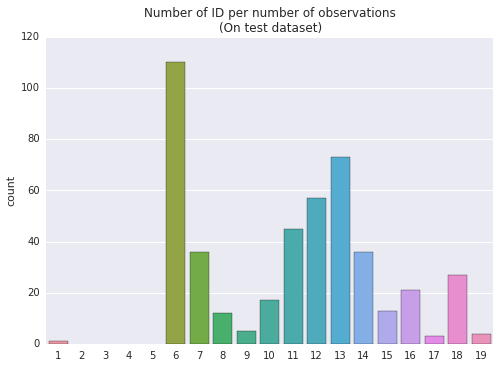

In [74]:
X=getX(test)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On test dataset)")
plt.plot()

In [15]:
testFull = test.dropna()

In [16]:
%%time
X=getX(testFull)  # 1min
XX = [np.array(t).mean(0) for t in X]  # 10s

CPU times: user 1min 12s, sys: 860 ms, total: 1min 13s
Wall time: 1min 14s


In [17]:
pd.DataFrame(etreg.predict(XX)).describe()

,0
count,235515.000000
mean,6.904250
std,7.382986
min,0.229492
25%,2.670935
50%,4.726779
75%,8.646297
max,344.055538


In [18]:
predFull = zip(testFull.index.unique(),etreg.predict(XX))

In [36]:
testNan = test.drop(test[features_columns].dropna(how='all').index)

In [37]:
tmp = np.empty(len(testNan))
tmp.fill(0.445000)   # 50th percentile of full Nan dataset
predNan = zip(testNan.index.unique(),tmp)

In [39]:
testLeft = test.drop(testNan.index.unique()).drop(testFull.index.unique())

In [40]:
tmp = np.empty(len(testLeft))
tmp.fill(1.27)   # 50th percentile of full Nan dataset
predLeft = zip(testLeft.index.unique(),tmp)

In [41]:
len(testFull.index.unique())

235515

In [42]:
len(testNan.index.unique())

232148

In [43]:
len(testLeft.index.unique())

249962

In [44]:
pred = predFull + predNan + predLeft

In [45]:
pred.sort(key=lambda x: x[0], reverse=False)

In [46]:
submission = pd.DataFrame(pred)
submission.columns = ["Id","Expected"]
submission.head()

,Id,Expected
0,1,1.270000
1,2,1.270000
2,3,8.287113
3,4,9.608633
4,5,0.445000


In [47]:
submission.to_csv("first_submit.csv",index=False)

In [34]:
filename = "data/sample_solution.csv"
sol = pd.read_csv(filename)

In [28]:
ss = np.array(sol)

In [30]:
%%time
for a,b in predFull:
    ss[a-1][1]=b

CPU times: user 361 ms, sys: 28.7 ms, total: 390 ms
Wall time: 369 ms


In [41]:
ss

array([[  1.00000000e+00,   8.57645300e-02],
       [  2.00000000e+00,   1.20000000e+01],
       [  3.00000000e+00,   8.28711271e+00],
       ..., 
       [  7.17623000e+05,   9.65720687e+00],
       [  7.17624000e+05,   1.29702251e+00],
       [  7.17625000e+05,   0.00000000e+00]])

In [45]:
sub = pd.DataFrame(ss)
sub.columns = ["Id","Expected"]
sub.Id = sub.Id.astype(int)
sub.head()

,Id,Expected
0,1,0.085765
1,2,12.000000
2,3,8.287113
3,4,9.608633
4,5,0.000000


In [46]:
sub.to_csv("submit_2.csv",index=False)